<a href="https://colab.research.google.com/github/yeesem/Soft-Computing/blob/main/WIX3001_Soft_Computing_Tutorial_10_Genetic_Programming.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install deap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 2.4 MB/s eta 0:00:00


In [7]:
import operator
import random
import numpy as np
import matplotlib.pyplot as plt
from deap import base, creator, gp, tools , algorithms


In [3]:
# Define the dataset
x = np.linspace(-1, 1, 100)
y = np.sin(x) + np.random.normal(0, 0.1, size=len(x))

In [4]:
# Define the evaluation function
def eval_sine(individual, x):
    # Compile the expression
    func = toolbox.compile(expr=individual)
    # Evaluate the expression on the data points
    y_pred = [func(xi) for xi in x]
    # Calculate Mean Squared Error (MSE)
    return np.mean((y_pred - y) ** 2),

In [5]:
# Create a primitive set for the GP
pset = gp.PrimitiveSet("MAIN", arity=1)
pset.addPrimitive(np.add, arity=2)
pset.addPrimitive(np.subtract, arity=2)
pset.addPrimitive(np.multiply, arity=2)
pset.addPrimitive(np.divide, arity=2)
pset.addPrimitive(np.sin, arity=1)
pset.addPrimitive(np.cos, arity=1)
pset.addPrimitive(np.exp, arity=1)
pset.addPrimitive(np.sqrt, arity=1)
pset.addPrimitive(np.abs, arity=1)
pset.addPrimitive(np.square, arity=1)
pset.addEphemeralConstant("rand", lambda: random.uniform(-1, 1))

# Define the type of the individual (program) and the fitness
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

# Create the toolbox
toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=3)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)
toolbox.register("evaluate", eval_sine, x=x)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("mutate", gp.mutNodeReplacement, pset=pset)
toolbox.register("select", tools.selTournament, tournsize=3)

# Set limits for tree depth
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=15))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=15))

/usr/local/lib/python3.10/dist-packages/deap/gp.py:254: RuntimeWarning: Ephemeral rand function cannot be pickled because its generating function is a lambda function. Use functools.partial instead.
  warnings.warn("Ephemeral {name} function cannot be "


<string>:1: RuntimeWarning: invalid value encountered in sqrt


Best Expression: <function <lambda> at 0x790793ce7eb0>


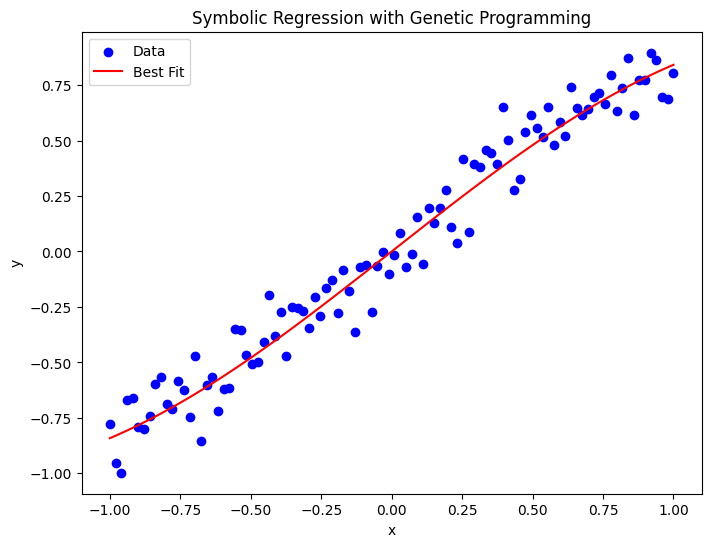

In [8]:
# Define parameters
population_size = 100
generations = 50
cxpb = 0.7
mutpb = 0.3

# Initialize population
population = toolbox.population(n=population_size)

# Run the evolution
for gen in range(generations):
    offspring = algorithms.varAnd(population, toolbox, cxpb=cxpb, mutpb=mutpb)
    fitnesses = toolbox.map(toolbox.evaluate, offspring)
    for ind, fit in zip(offspring, fitnesses):
        ind.fitness.values = fit
    population = toolbox.select(offspring, k=len(population))

# Get the best individual
best_individual = tools.selBest(population, k=1)[0]
best_expression = toolbox.compile(expr=best_individual)
print("Best Expression:", best_expression)

# Plot the best individual
plt.figure(figsize=(8, 6))
plt.scatter(x, y, color='blue', label='Data')
plt.plot(x, [best_expression(xi) for xi in x], color='red', label='Best Fit')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Symbolic Regression with Genetic Programming')
plt.show()

In [9]:
population_sizes = [50, 100, 200]
num_generations = [50, 100, 200]
crossover_probs = [0.5, 0.7, 0.9]
mutation_probs = [0.1, 0.3, 0.5]

In [10]:
def runGP(popsize, maxgen, rate_cr, rate_mu):
  population = toolbox.population(n=popsize)
  record_fitness = {
      'bestfit': [],
      'avgfit': [],
      'generation': []
  }

  # Run the evolution
  for gen in range(maxgen):
      offspring = algorithms.varAnd(population, toolbox, cxpb=rate_cr, mutpb=rate_mu)
      fitnesses = toolbox.map(toolbox.evaluate, offspring)

      fit_total = 0
      for ind, fit in zip(offspring, fitnesses):
          ind.fitness.values = fit
          fit_total += fit[0]
      population = toolbox.select(offspring, k=len(population))

      record_fitness['bestfit'] += [tools.selBest(population, k=1)[0].fitness.values[0]]
      record_fitness['avgfit'] += [fit_total/popsize]
      record_fitness['generation'] += [gen]

  return population, record_fitness

In [11]:
# Define lists to store results
results = {
    'bestindividual': [],
    'bestfitness': [],
    'avgfitness': [],
    'progression': [],
    'popsize': [],
    'generations': [],
    'crossover': [],
    'mutation': []
}

In [12]:
for popsize in population_sizes:
  for maxgen in num_generations:
    for rate_cr in crossover_probs:
      for rate_mu in mutation_probs:
        print("Running for popsize {}, maxgen {}, cro {}, mut {}".format(popsize, maxgen, rate_cr, rate_mu))

        population, record_fitness = runGP(popsize, maxgen, rate_cr, rate_mu)

        # Get the best individual and its fitness
        results['bestindividual'] += [tools.selBest(population, k=1)[0]]
        results['bestfitness'] += [results['bestindividual'][-1].fitness.values[0]]

        results['progression'] += [record_fitness]

        # Average fitness
        total_fitness = 0.0
        for ind in population:
            total_fitness += ind.fitness.values[0]
        results['avgfitness'] += [total_fitness / len(population)]

        results['popsize'] += [popsize]
        results['generations'] += [maxgen]
        results['crossover'] += [rate_cr]
        results['mutation'] += [rate_mu]

Running for popsize 50, maxgen 50, cro 0.5, mut 0.1
Running for popsize 50, maxgen 50, cro 0.5, mut 0.3
Running for popsize 50, maxgen 50, cro 0.5, mut 0.5


<string>:1: RuntimeWarning: divide by zero encountered in divide


Running for popsize 50, maxgen 50, cro 0.7, mut 0.1
Running for popsize 50, maxgen 50, cro 0.7, mut 0.3
Running for popsize 50, maxgen 50, cro 0.7, mut 0.5
Running for popsize 50, maxgen 50, cro 0.9, mut 0.1
Running for popsize 50, maxgen 50, cro 0.9, mut 0.3
Running for popsize 50, maxgen 50, cro 0.9, mut 0.5
Running for popsize 50, maxgen 100, cro 0.5, mut 0.1
Running for popsize 50, maxgen 100, cro 0.5, mut 0.3
Running for popsize 50, maxgen 100, cro 0.5, mut 0.5


<string>:1: RuntimeWarning: invalid value encountered in sin


Running for popsize 50, maxgen 100, cro 0.7, mut 0.1
Running for popsize 50, maxgen 100, cro 0.7, mut 0.3
Running for popsize 50, maxgen 100, cro 0.7, mut 0.5
Running for popsize 50, maxgen 100, cro 0.9, mut 0.1
Running for popsize 50, maxgen 100, cro 0.9, mut 0.3
Running for popsize 50, maxgen 100, cro 0.9, mut 0.5
Running for popsize 50, maxgen 200, cro 0.5, mut 0.1
Running for popsize 50, maxgen 200, cro 0.5, mut 0.3
Running for popsize 50, maxgen 200, cro 0.5, mut 0.5
Running for popsize 50, maxgen 200, cro 0.7, mut 0.1
Running for popsize 50, maxgen 200, cro 0.7, mut 0.3
Running for popsize 50, maxgen 200, cro 0.7, mut 0.5
Running for popsize 50, maxgen 200, cro 0.9, mut 0.1
Running for popsize 50, maxgen 200, cro 0.9, mut 0.3
Running for popsize 50, maxgen 200, cro 0.9, mut 0.5


<string>:1: RuntimeWarning: overflow encountered in exp
<string>:1: RuntimeWarning: invalid value encountered in cos


Running for popsize 100, maxgen 50, cro 0.5, mut 0.1
Running for popsize 100, maxgen 50, cro 0.5, mut 0.3
Running for popsize 100, maxgen 50, cro 0.5, mut 0.5
Running for popsize 100, maxgen 50, cro 0.7, mut 0.1
Running for popsize 100, maxgen 50, cro 0.7, mut 0.3
Running for popsize 100, maxgen 50, cro 0.7, mut 0.5
Running for popsize 100, maxgen 50, cro 0.9, mut 0.1
Running for popsize 100, maxgen 50, cro 0.9, mut 0.3
Running for popsize 100, maxgen 50, cro 0.9, mut 0.5
Running for popsize 100, maxgen 100, cro 0.5, mut 0.1
Running for popsize 100, maxgen 100, cro 0.5, mut 0.3
Running for popsize 100, maxgen 100, cro 0.5, mut 0.5
Running for popsize 100, maxgen 100, cro 0.7, mut 0.1
Running for popsize 100, maxgen 100, cro 0.7, mut 0.3
Running for popsize 100, maxgen 100, cro 0.7, mut 0.5
Running for popsize 100, maxgen 100, cro 0.9, mut 0.1
Running for popsize 100, maxgen 100, cro 0.9, mut 0.3


<ipython-input-4-a8c5f503a672>:8: RuntimeWarning: overflow encountered in square
  return np.mean((y_pred - y) ** 2),


Running for popsize 100, maxgen 100, cro 0.9, mut 0.5
Running for popsize 100, maxgen 200, cro 0.5, mut 0.1


<string>:1: RuntimeWarning: invalid value encountered in multiply


Running for popsize 100, maxgen 200, cro 0.5, mut 0.3
Running for popsize 100, maxgen 200, cro 0.5, mut 0.5
Running for popsize 100, maxgen 200, cro 0.7, mut 0.1


<string>:1: RuntimeWarning: invalid value encountered in divide


Running for popsize 100, maxgen 200, cro 0.7, mut 0.3
Running for popsize 100, maxgen 200, cro 0.7, mut 0.5
Running for popsize 100, maxgen 200, cro 0.9, mut 0.1
Running for popsize 100, maxgen 200, cro 0.9, mut 0.3
Running for popsize 100, maxgen 200, cro 0.9, mut 0.5
Running for popsize 200, maxgen 50, cro 0.5, mut 0.1
Running for popsize 200, maxgen 50, cro 0.5, mut 0.3
Running for popsize 200, maxgen 50, cro 0.5, mut 0.5
Running for popsize 200, maxgen 50, cro 0.7, mut 0.1
Running for popsize 200, maxgen 50, cro 0.7, mut 0.3
Running for popsize 200, maxgen 50, cro 0.7, mut 0.5
Running for popsize 200, maxgen 50, cro 0.9, mut 0.1
Running for popsize 200, maxgen 50, cro 0.9, mut 0.3
Running for popsize 200, maxgen 50, cro 0.9, mut 0.5
Running for popsize 200, maxgen 100, cro 0.5, mut 0.1
Running for popsize 200, maxgen 100, cro 0.5, mut 0.3
Running for popsize 200, maxgen 100, cro 0.5, mut 0.5
Running for popsize 200, maxgen 100, cro 0.7, mut 0.1
Running for popsize 200, maxgen 100, 